In [76]:
#Access database

import sqlite3, pandas as pd
#from Ipython.display import display

db_file = r"data\score.db"
conn = None
try:
    conn = sqlite3.connect(db_file)
except sqlite3.Error as e:
    print(e)

In [77]:
#Find the Table Names in the database
query = '''
    SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
    '''
tables = pd.read_sql_query(query, conn)
tables

,name
0,score


In [78]:
#Load the score table into a DataFrame

query = '''
    SELECT * FROM score
    '''
df = pd.read_sql_query(query, conn)

### List of attributes from the PDF:

|Attribute | Description |
| --- | --- |
student_id | Unique ID for each student
number_of_siblings | Number of siblings
direct_admission |Mode of entering the school
CCA |Enrolled CCA
learning_style |Primary learning style
tuition |Indication of whether the student has a tuition
final_test |Student’s O-level mathematics examination score
n_male |Number of male classmates
n_female| Number of female classmates
gender |Gender type
age |Age of the student
hours_per_week |Number of hours student studies per week
attendance_rate |Attendance rate of the student (%)
sleep_time |Daily sleeping time (hour:minutes)
wake_time |Daily waking up time (hour:minutes)
mode_of_transport |Mode of transport to school
bag_color |Colour of student’s bag

From the PDF, it looks like this table is regarding multiple independent variables about students' baseline characteristics as well as the dependent variable of their final test scores 

From here I postulate that:
1. We are looking at the various baseline characteristics and the effect on the students' final test scores
2. We will have  probably have to do split the data by gender and do a separate analysis on each group to see if the number of same gender/ opposite gender classmates affect final test scores


In [79]:
df.shape

(15900, 18)

There are 18 observations and 18 variables in the score table

In [80]:
#Explore the score table
df.head()

,index,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color
0,0,0,Yes,Sports,Visual,ACN2BE,Female,No,69.0,14.0,2.0,16.0,10.0,91.0,22:00,6:00,private transport,yellow
1,1,2,No,Sports,Auditory,FGXIIZ,Female,No,47.0,4.0,19.0,16.0,7.0,94.0,22:30,6:30,private transport,green
2,2,0,Yes,None,Visual,B9AI9F,Male,No,85.0,14.0,2.0,15.0,8.0,92.0,22:30,6:30,private transport,white
3,3,1,No,Clubs,Auditory,FEVM1T,Female,Yes,64.0,2.0,20.0,15.0,18.0,NaN,21:00,5:00,public transport,yellow
4,4,0,No,Sports,Auditory,AXZN2E,Male,No,66.0,24.0,3.0,16.0,7.0,95.0,21:30,5:30,public transport,yellow


Noted that there is an index column, without which, there are 17 independent variables

In [81]:
#Explore the score table
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15900 entries, 0 to 15899
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               15900 non-null  int64  
 1   number_of_siblings  15900 non-null  int64  
 2   direct_admission    15900 non-null  object 
 3   CCA                 15900 non-null  object 
 4   learning_style      15900 non-null  object 
 5   student_id          15900 non-null  object 
 6   gender              15900 non-null  object 
 7   tuition             15900 non-null  object 
 8   final_test          15405 non-null  float64
 9   n_male              15900 non-null  float64
 10  n_female            15900 non-null  float64
 11  age                 15900 non-null  float64
 12  hours_per_week      15900 non-null  float64
 13  attendance_rate     15122 non-null  float64
 14  sleep_time          15900 non-null  object 
 15  wake_time           15900 non-null  object 
 16  mode

"number of siblings" is the only integer variable among the numerical variables
And there a few columns with null values

In [82]:
#Explore the score table
df.describe()

,index,number_of_siblings,final_test,n_male,n_female,age,hours_per_week,attendance_rate
count,15900.000000,15900.000000,15405.000000,15900.000000,15900.000000,15900.000000,15900.000000,15122.000000
mean,7949.500000,0.886541,67.165401,13.880000,8.906038,15.213459,10.312579,93.270268
std,4590.078975,0.751346,13.977879,6.552584,6.663852,1.758941,4.461861,7.984230
min,0.000000,0.000000,32.000000,0.000000,0.000000,-5.000000,0.000000,40.000000
25%,3974.750000,0.000000,56.000000,10.000000,4.000000,15.000000,7.000000,92.000000
50%,7949.500000,1.000000,68.000000,14.000000,8.000000,15.000000,9.000000,95.000000
75%,11924.250000,1.000000,78.000000,18.000000,13.000000,16.000000,14.000000,97.000000
max,15899.000000,2.000000,100.000000,31.000000,31.000000,16.000000,20.000000,100.000000


Of which 7 (not counting the index column) are quantitative variables which mean 10 are categorical variables

And looks like we have some outliers in the age column where the minimum cannot be negative, that's something to look out for

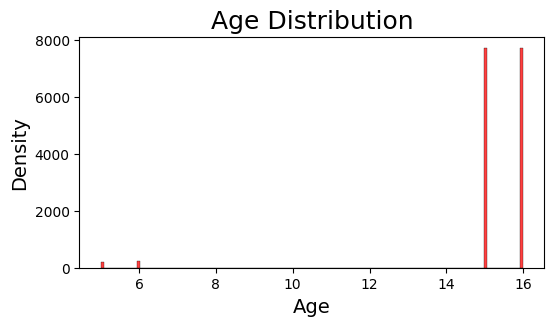

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
sns.histplot(df.age,color='r')
plt.title('Age Distribution',size=18)
plt.xlabel('Age',size=14)
plt.ylabel('Density',size=14)
plt.show()

Looks like most of the students are 15 and 16 years old. Let's see how many of them are not in this age range

In [84]:
from collections import Counter

count = Counter(df.age)
count

Counter({15.0: 7726, 16.0: 7723, 6.0: 230, 5.0: 216, -5.0: 4, -4.0: 1})

Looks like there are 2 groups of students, those 15-16yo and those 5-6yo. We can perhaps analyse them differently. 

Records with Negative ages will be removed since they are insignficant (only 5 records out of 15.9k)

In [85]:
#Remove records with negative ages
df = df[df.age > 0]

In [86]:
#Check for null values
df.isnull().sum()

index                   0
number_of_siblings      0
direct_admission        0
CCA                     0
learning_style          0
student_id              0
gender                  0
tuition                 0
final_test            495
n_male                  0
n_female                0
age                     0
hours_per_week          0
attendance_rate       778
sleep_time              0
wake_time               0
mode_of_transport       0
bag_color               0
dtype: int64

Final_test and attendance_rate have null values, we will need to find a way to manage these null values

In [87]:
print('Ratio of null values in the final_test column: ', df['final_test'].isnull().sum()/df['final_test'].count())
print('Ratio of null values in the attendance_rate column: ', df['attendance_rate'].isnull().sum()/df['attendance_rate'].count())
print('Ratio of null values in any column: ', df.isnull().any(axis = 1).sum()/df.shape[0])

Ratio of null values in the final_test column:  0.03214285714285714
Ratio of null values in the attendance_rate column:  0.051465237811735134
Ratio of null values in any column:  0.07876690783265178


Since the number of rows with missing values < 10%, it is likely insignificant and i will be removing these rows
We will explore these after the main analysis

In [88]:
#Remove rows with null values
df_nonull = df[~df.isnull().any(axis = 1)]
df_nonull.isnull().sum() #check if it has been implemented correctly

index                 0
number_of_siblings    0
direct_admission      0
CCA                   0
learning_style        0
student_id            0
gender                0
tuition               0
final_test            0
n_male                0
n_female              0
age                   0
hours_per_week        0
attendance_rate       0
sleep_time            0
wake_time             0
mode_of_transport     0
bag_color             0
dtype: int64

In [89]:
#Check for duplicates
df_nonull[df_nonull.duplicated(keep = 'first')]

,index,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color


No duplicate rows found

Let's recheck to see if the 5 and 6 year olds are still in the table

In [90]:

count = Counter(df_nonull.age)
count

Counter({15.0: 7117, 16.0: 7112, 6.0: 215, 5.0: 199})

Yes they are, we can still do a separate analysis on this group

In [91]:
df_older = df[df.age >= 15]
df_younger = df[df.age < 15]

Now we will explore pairplots of the numerical values

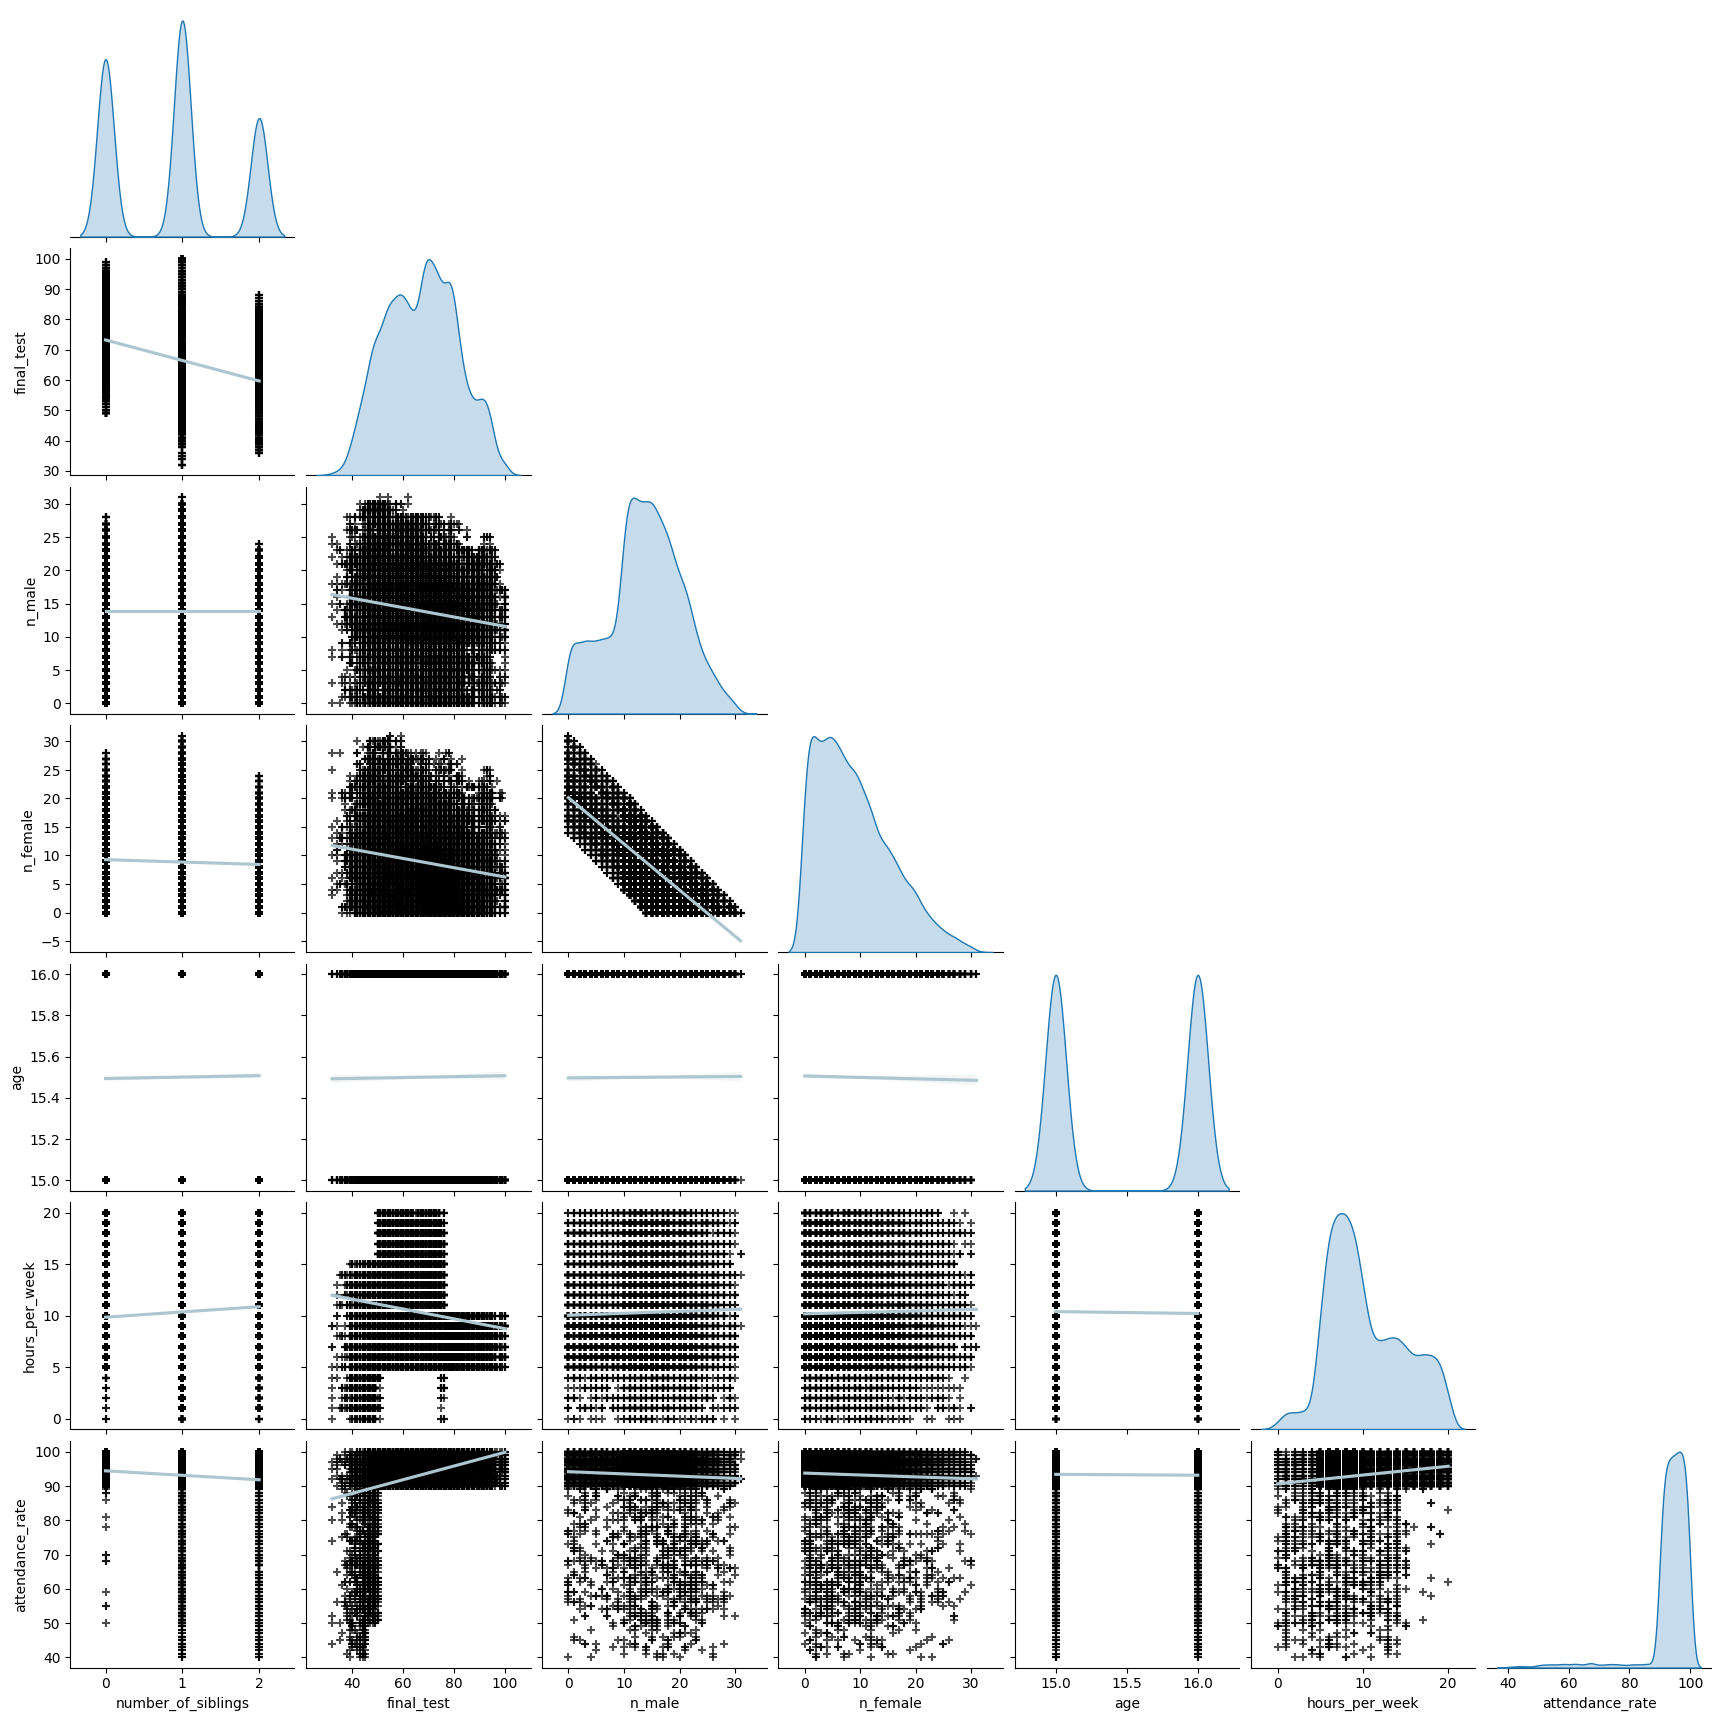

In [95]:
#For the Older group
#less the index column
sns.pairplot(df_older.iloc[:,1:], 
                 markers="+",
                 diag_kind="kde",
                 kind='reg',
                 plot_kws={'line_kws':{'color':'#aec6cf'}, 
                           'scatter_kws': {'alpha': 0.7, 
                                           'color': 'black'}},
                 corner=True);

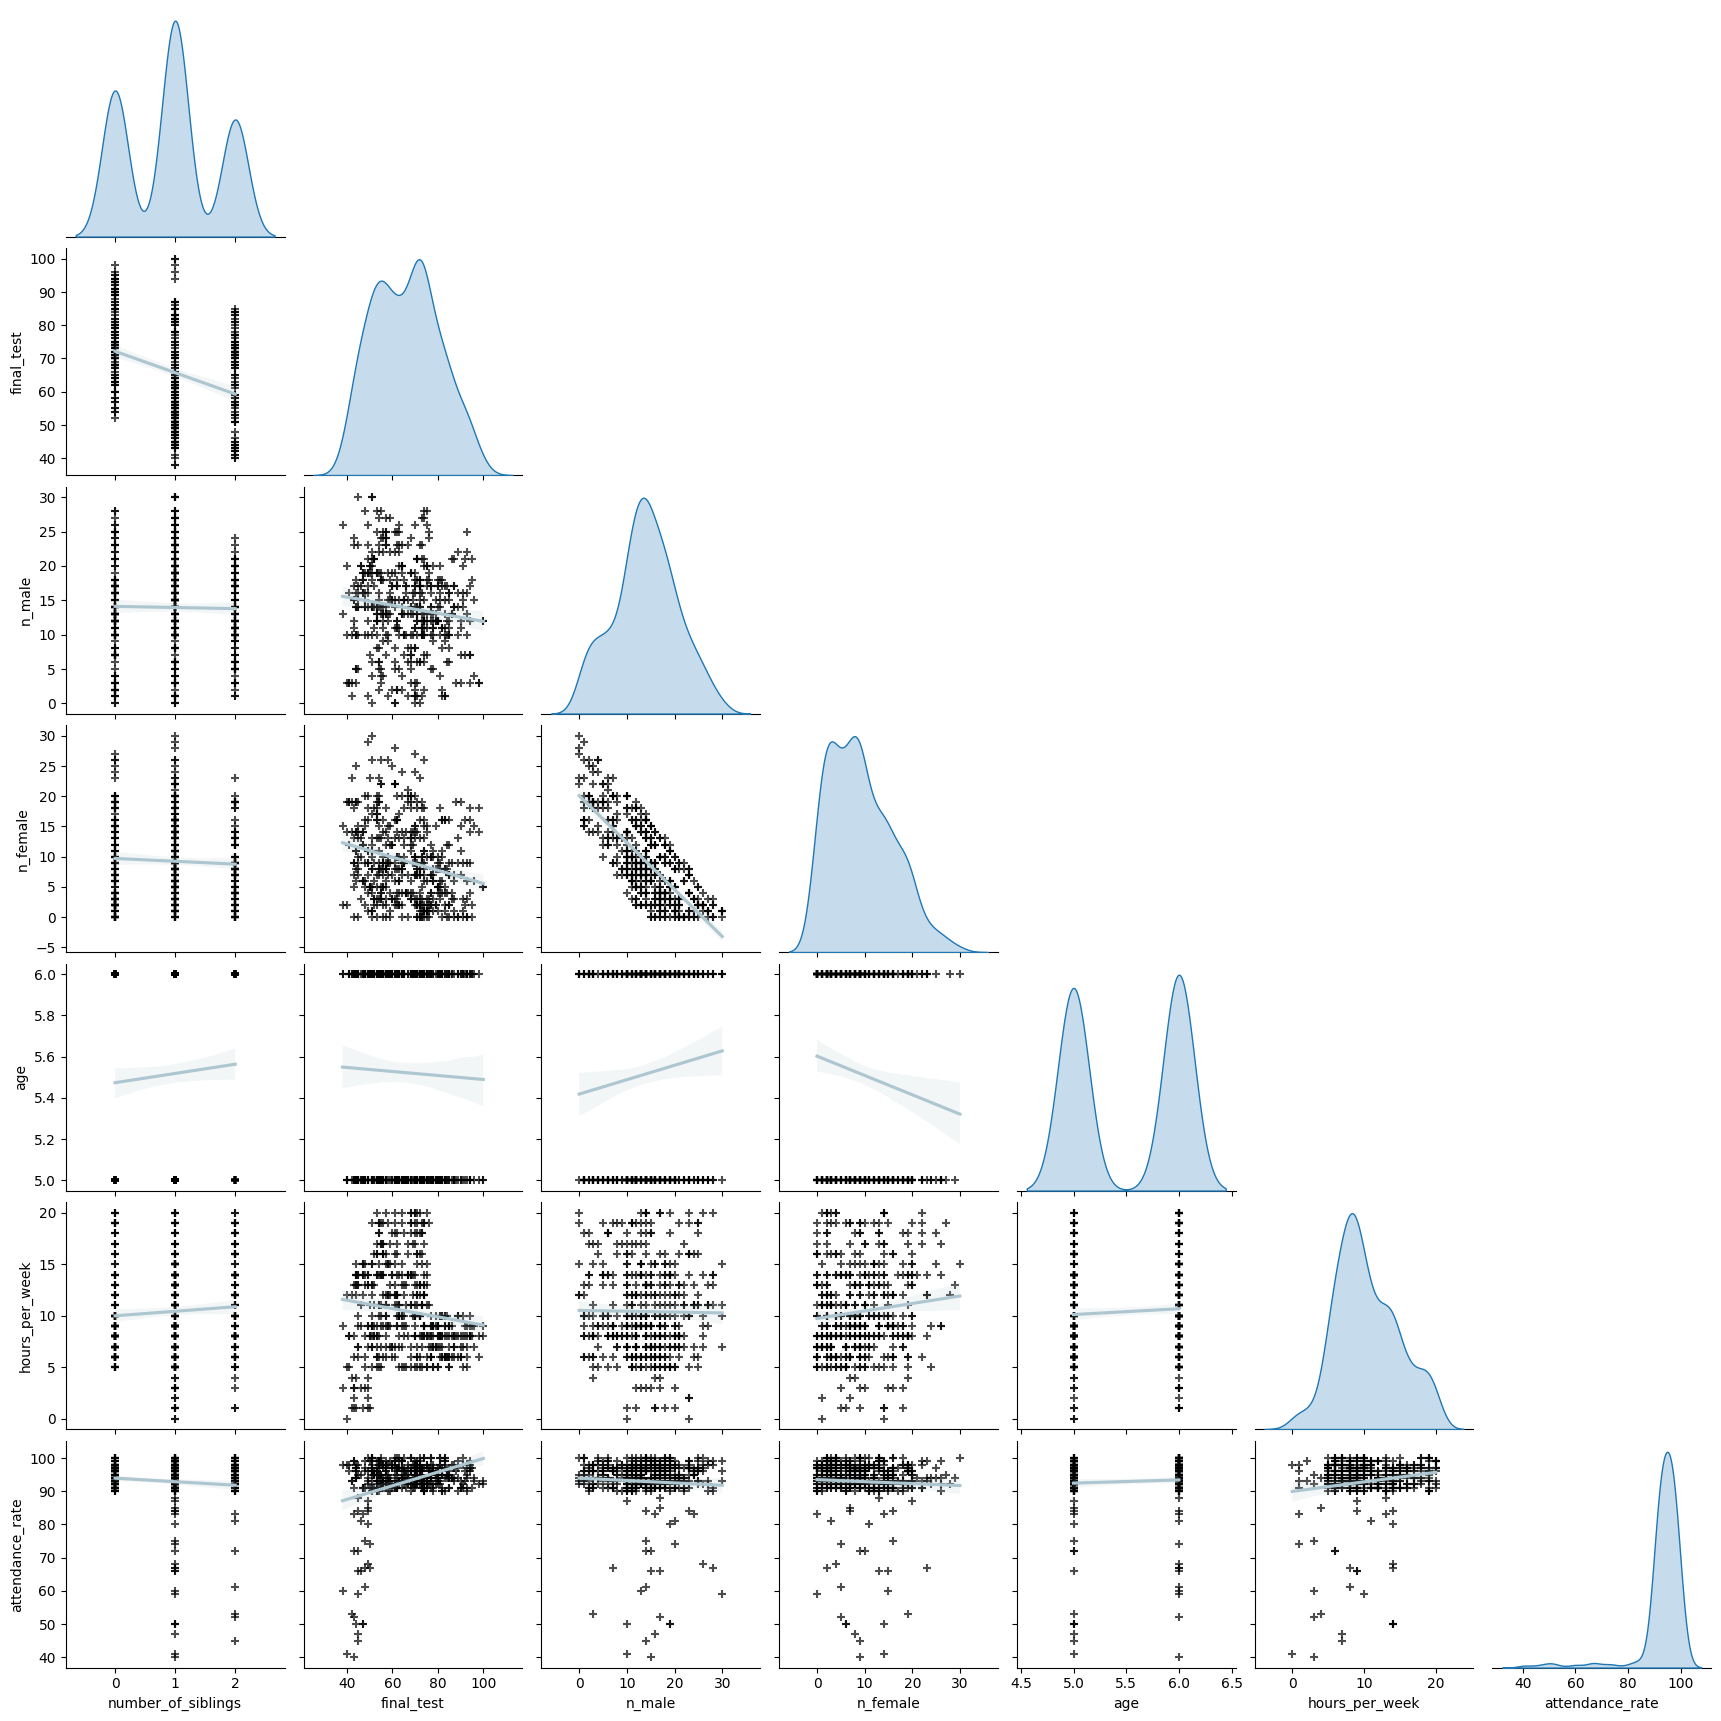

In [94]:
#For the Younger group
#less the index column
sns.pairplot(df_younger.iloc[:,1:], 
                 markers="+",
                 diag_kind="kde",
                 kind='reg',
                 plot_kws={'line_kws':{'color':'#aec6cf'}, 
                           'scatter_kws': {'alpha': 0.7, 
                                           'color': 'black'}},
                 corner=True);

...... Conclusion for the pairwise plots

Find the Vix and multicollinearity....

References:
1. https://www.sqlitetutorial.net/sqlite-python/sqlite-python-select/
2. https://medium.com/@ugursavci/complete-exploratory-data-analysis-using-python-9f685d67d1e4
3. https://medium.com/@dilip.voleti/multicollinearity-in-machine-learning-26d652b183de